## Fruit Image Classifier - Part 1: Imports & Preprocessing


In [19]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# src imports
from gpu_utils import CheckGPU, CheckCUDA, CheckGPUBrief
from dataset_counter import CountDataset

#### Detect GPU Available, Details, Cuda, and cuDNN

In [20]:
# From 
CheckGPU()
CheckCUDA()

🖥️  GPU INFORMATION
✅ GPU Detected         : NVIDIA GeForce RTX 2060
   • Device ID          : 0
   • Compute Capability : 7.5
   • Multiprocessors    : 30
   • Total VRAM         : 6.00 GB
   • VRAM Allocated     : 0.00 GB
   • VRAM Reserved      : 0.00 GB
   • Active Device      : cuda

⚡ CUDA / PYTORCH INFORMATION
✅ CUDA Available       : True
   • PyTorch CUDA Ver.  : 11.8
   • PyTorch Version    : 2.7.1+cu118
✅ cuDNN Version        : 90100
   • CUDA Device Count  : 1
   • Device 0 Name     : NVIDIA GeForce RTX 2060


### Configuration Variables

In [21]:
# Adjustable Conf

# Dataset
DATASET_DIR = "../dataset"

# Image settings
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Data split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Normalization values (commonly used for RGB datasets like ImageNet)
# Can adjust this if want to compute the mean/std of the dataset
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# Augmentation settings (set to False to disable any augmentation)
USE_AUGMENTATION = True

USE_WEIGHTED_SAMPLER = True

# Batch Size
BATCH_SIZE = 32
NUM_CLASSES = 5

MODEL_SAVE_PATH = "resnet50_fruit_classifier.pth"

# Seed for reproducibility
SEED = 42



#  SET RANDOM SEEDS
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

#### Dataset Information

In [22]:
dataset_info = CountDataset(DATASET_DIR)
'''
===============================================================
Class       count       ratio     needed    size_mb
===============================================================
Apple        5061      1.0000          0      229.93 MB
Banana       5061      1.0000          0      153.37 MB
Grapes       5061      1.0000          0      641.90 MB
Mango        4172      0.8243        889      200.80 MB
Orange       2788      0.5509       2273      360.60 MB
===============================================================
total_images  22143
max_class_count   5061
total_size_mb                                   1586.59 MB
===============================================================
}
'''


📊 DATASET SUMMARY
Class       count       ratio     needed        size_mb
Apple        5061      1.0000          0      229.93 MB
Banana       5061      1.0000          0      153.37 MB
Grapes       5061      1.0000          0      641.90 MB
Mango        4172      0.8243        889      200.80 MB
Orange       2788      0.5509       2273      360.60 MB
total_images  22143
max_class_count   5061
total_size_mb                                   1586.59 MB


'\n===============================================================\nClass       count       ratio     needed    size_mb\n===============================================================\nApple        5061      1.0000          0      229.93 MB\nBanana       5061      1.0000          0      153.37 MB\nGrapes       5061      1.0000          0      641.90 MB\nMango        4172      0.8243        889      200.80 MB\nOrange       2788      0.5509       2273      360.60 MB\n===============================================================\ntotal_images  22143\nmax_class_count   5061\ntotal_size_mb                                   1586.59 MB\n===============================================================\n}\n'

### DEFINE TRANSFORMS

In [23]:
if USE_AUGMENTATION:
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
    ])
else:
    train_transforms = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
    ])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

#### LOAD FULL DATASET & TRAIN/VAL/TEST SPLIT

In [24]:
# LOAD FULL DATASET
full_dataset = datasets.ImageFolder(root=DATASET_DIR, transform=train_transforms)
num_total = len(full_dataset)

# TRAIN/VAL/TEST SPLIT
train_size = int(TRAIN_RATIO * num_total)
val_size = int(VAL_RATIO * num_total)
test_size = num_total - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Apply different transforms for val and test
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms


#### CLASS WEIGHTS FOR IMBALANCED DATA

In [25]:
class_counts = np.bincount([label for _, label in full_dataset.samples])
class_weights = 1.0 / class_counts
print(f"⚖️ Class counts: {class_counts}")
print(f"⚖️ Class weights: {class_weights}")

# Sampler for training (optional)
if USE_WEIGHTED_SAMPLER:
    train_targets = [full_dataset.samples[i][1] for i in train_dataset.indices]
    sample_weights = [class_weights[t] for t in train_targets]


⚖️ Class counts: [5061 5061 5061 4172 2788]
⚖️ Class weights: [0.00019759 0.00019759 0.00019759 0.00023969 0.00035868]


#### Dataloaders

In [26]:
if USE_WEIGHTED_SAMPLER:
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=sampler
    )
else:
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

#### PRINT SUMMARY

In [27]:
print(f"📊 Total images: {num_total}")
print(f"   Train: {train_size}")
print(f"   Val:   {val_size}")
print(f"   Test:  {test_size}")
print(f"🖼️ Image size: {IMG_HEIGHT} x {IMG_WIDTH}")
print(f"🪄 Augmentation: {'ON' if USE_AUGMENTATION else 'OFF'}")
print(f"⚖️ Class counts: {class_counts.tolist()}")
print(f"⚖️ Class weights: {class_weights.tolist()}")
print(f"🧪 Batch size: {BATCH_SIZE}")

📊 Total images: 22143
   Train: 15500
   Val:   3321
   Test:  3322
🖼️ Image size: 224 x 224
🪄 Augmentation: ON
⚖️ Class counts: [5061, 5061, 5061, 4172, 2788]
⚖️ Class weights: [0.00019758940920766647, 0.00019758940920766647, 0.00019758940920766647, 0.00023969319271332693, 0.0003586800573888092]
🧪 Batch size: 32


In [28]:
#### MODEL TRAINING KEY VARIABLES

In [29]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
NUM_CLASSES = len(class_counts)
LEARNING_RATE = 0.0001
EPOCHS = 5

# Training history dictionary (global)
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

#### Load the Pretrained ResNet50 Base

In [30]:
# Load a pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Replace the final fully connected layer to match your number of classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#### LOSS & OPTIMIZER

In [31]:
# Use CrossEntropyLoss (can apply class weights if dataset is imbalanced)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Optional: Learning rate scheduler (optional but useful)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### TRAINING & VALIDATION LOOP

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    best_acc = 0.0
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        print(f"\n📆 Epoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        epoch_train_corrects = 0
        epoch_val_corrects = 0

        #  TRAIN & VALIDATION LOOP
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            loop = tqdm(
                dataloader,
                total=len(dataloader),
                desc=f"{phase.upper()} Epoch {epoch+1}/{num_epochs}",
                leave=False
            )

            for inputs, labels in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Step the LR scheduler only after the training phase
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                epoch_train_loss = epoch_loss
                epoch_train_corrects = epoch_acc
            else:
                epoch_val_loss = epoch_loss
                epoch_val_corrects = epoch_acc

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()

        #  SAVE METRICS TO HISTORY
        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_acc"].append(epoch_train_corrects.item())
        history["val_acc"].append(epoch_val_corrects.item())

    print(f"\n✅ Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

CheckGPUBrief()

🟢 GPU: NVIDIA GeForce RTX 2060 | 💾 VRAM: 6.00 GB
🧠 PyTorch: 2.7.1+cu118 | 🧰 cuDNN: 90100


#### TRAIN THE MODEL & SAVE THE TRAINED MODEL

In [33]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS)

torch.save(model.state_dict(), "../models/resnet50_fruit_classifier.pth")
print("✅ Model saved as resnet50_fruit_classifier.pth")


📆 Epoch 1/5
----------------------------------------


Train Loss: 0.0598 | Acc: 0.9827


Val Loss: 0.0252 | Acc: 0.9922

📆 Epoch 2/5
----------------------------------------


Train Loss: 0.0243 | Acc: 0.9922


Val Loss: 0.0208 | Acc: 0.9916

📆 Epoch 3/5
----------------------------------------


Train Loss: 0.0226 | Acc: 0.9923


Val Loss: 0.0137 | Acc: 0.9961

📆 Epoch 4/5
----------------------------------------


Train Loss: 0.0103 | Acc: 0.9968


Val Loss: 0.0080 | Acc: 0.9973

📆 Epoch 5/5
----------------------------------------


Train Loss: 0.0105 | Acc: 0.9965


Val Loss: 0.0090 | Acc: 0.9976

✅ Best Validation Accuracy: 0.9976
✅ Model saved as resnet50_fruit_classifier.pth


✅ More epochs → the model learns more patterns.

⚠️ But too many epochs can lead to overfitting — when the model memorizes the training data and performs poorly on new data.

Too few epochs can lead to underfitting — when the model hasn’t learned enough.

📝 Tip: Start with 10–20 epochs, then increase if the model is still improving.

#### Plotting Training Curves

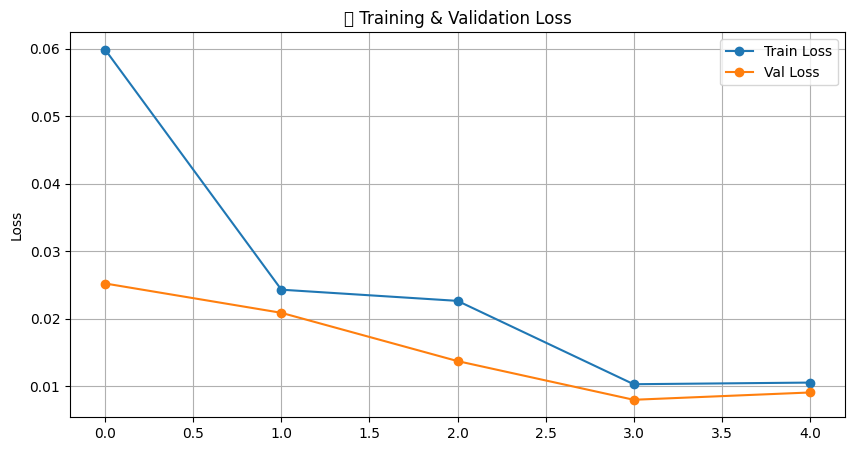

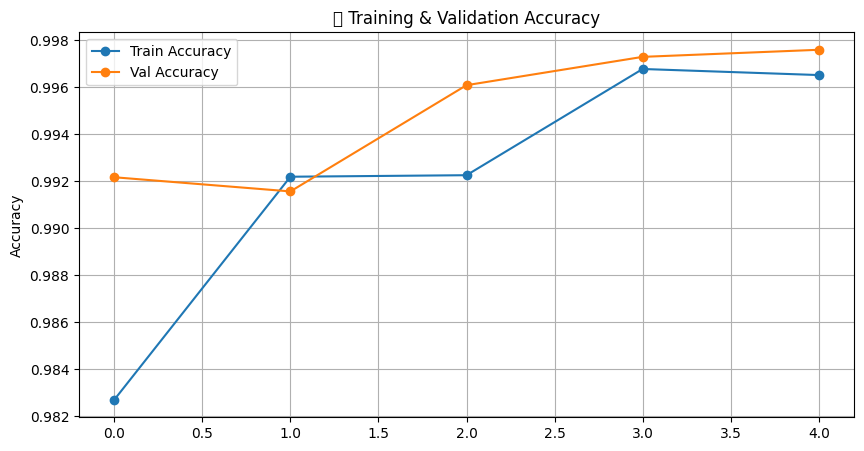

In [ ]:
# --- Accuracy Plot ---
plt.figure(figsize=(10, 5))
plt.plot(history["train_acc"], label="Train Accuracy", marker='o')
plt.plot(history["val_acc"], label="Val Accuracy", marker='o')
plt.title("📈 Training & Validation Accuracy")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss", marker='o')
plt.plot(history["val_loss"], label="Val Loss", marker='o')
plt.title("📉 Training & Validation Loss")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### 3. Confusion Matrix

A confusion matrix provides a more detailed view of classification results.
It shows how many times the model correctly predicted each class versus how many times it confused it with another.

<Figure size 800x600 with 0 Axes>

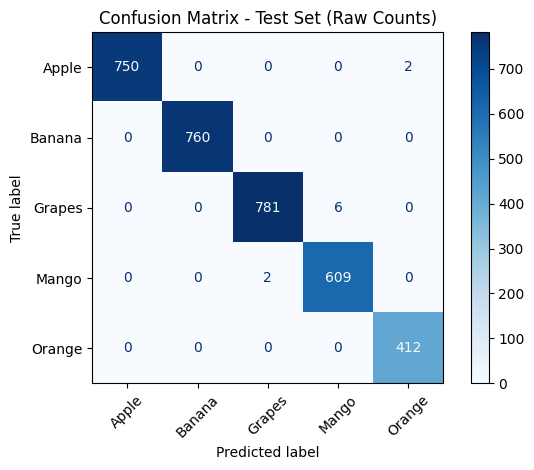

<Figure size 800x600 with 0 Axes>

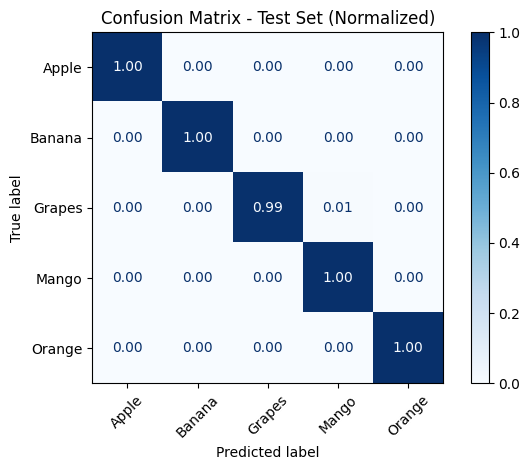

In [38]:
# 📊 Collect predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 🧮 Compute confusion matrix (not normalized)
cm = confusion_matrix(all_labels, all_preds)

# ✅ Get class names from original ImageFolder dataset
class_names = full_dataset.classes

# 📈 Plot raw confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45, colorbar=True)
plt.title("Confusion Matrix - Test Set (Raw Counts)")
plt.tight_layout()
plt.show()

# 🧮 Compute normalized confusion matrix
cm_normalized = confusion_matrix(all_labels, all_preds, normalize='true')

# 📈 Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp_norm.plot(cmap='Blues', xticks_rotation=45, values_format='.2f', colorbar=True)
plt.title("Confusion Matrix - Test Set (Normalized)")
plt.tight_layout()
plt.show()

🧠 How to read the confusion matrix:

Diagonal values = correct predictions ✅

Off-diagonal values = misclassifications ❌

A perfect model would have non-zero values only along the diagonal.